# Exploring stars in the CVZs.

Trying to figure out how many stars of each spectral type are in the CVZs, using queries sent via CasJobs.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import kinematics_and_rotation as kr

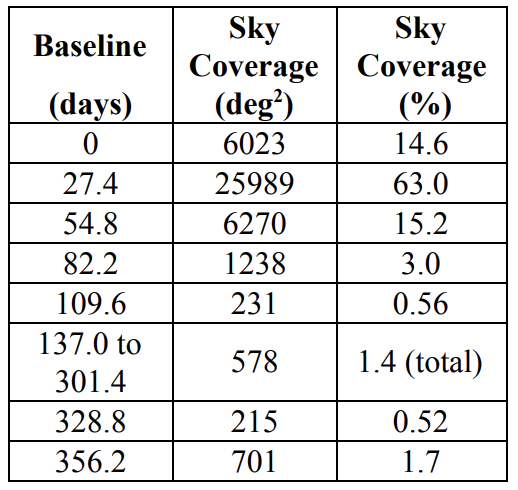

In [4]:
from IPython.display import Image
Image("table.png", width=300)

In [5]:
baseline = np.array([0, 27.4, 54.8, 82.2, 109.6, (137.0+301.4)/2, 328.8, 356.2])
sky_coverage = np.array([14.6, 63.0, 15.2, 3.0, .56, 1.4, .52, 1.7])

total_coverage = 100 - sky_coverage[0]
cvz_coverage_frac = sky_coverage[-1]/total_coverage

print(total_coverage, cvz_coverage_frac)

85.4 0.019906323185011707


Load the TESS CVZ catalogs.

In [208]:
north = pd.read_csv("../../data/northern_cvz_16th.csv")
south = pd.read_csv("../../data/southern_cvz_16th.csv")
north = north.iloc[north.Tmag.values <= 15]
south = south.iloc[south.Tmag.values <= 15]
tess = pd.concat((north, south))#, on=["ID", "Teff", "mass", "Tmag"])
tess = tess.drop_duplicates()

Load Kepler and MEarth catalogs.

In [209]:
kepler = pd.read_csv("../../../aviary/code/all_rvs.csv")
kepler = kepler.drop_duplicates()
kepler["source"] = ["kepler"] * len(kepler)
d = (kepler.abs_G.values > 4) & (kepler.Prot.values > 1.5)
kepler = kepler.iloc[d]
k = pd.DataFrame(dict({"mass": kepler.Mass_berger.values,
                       "teff": kepler.Teff.values,
                       "prot": kepler.Prot.values}))

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [210]:
from scipy import interpolate

def mass_to_teff(mass):
    df = pd.read_csv("mamajek_table.csv", usecols=["Teff", "Msun"])
    f = interpolate.interp1d(df.Msun, df.Teff)
    return f(mass)

In [211]:
mearth = pd.read_csv("/Users/rangus/projects/aviary/data/newton_kinematics.csv", skiprows=73, usecols=["Mass", "Per", "W"],
                     delimiter=";", dtype="float64")
mearth = mearth.iloc[(mearth.Mass.values > .08) & (mearth.Per.values < 150) & (1.5 < mearth.Per.values)]
print(mearth.keys())
teff = kr.mass_to_teff(mearth.Mass.values)
m = pd.DataFrame(dict({"mass": mearth.Mass.values,
                       "prot": mearth.Per.values,
                       "teff": teff}))

Index(['W', 'Per', 'Mass'], dtype='object')


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:688: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


In [212]:
df = pd.concat((k, m))

In [238]:
teff_bins = np.arange(2500, 6500, 100)

Calculate period median and stdev for every teff bin.

In [239]:
period_mean, period_std = [np.zeros(len(teff_bins)-1) for i in range(2)]
sim_logp, sim_t = [], []
for i in range(len(teff_bins)-1):
    tmask = (teff_bins[i] < df.teff.values) & (df.teff.values < teff_bins[i+1])
    
    ninety_fifth, fifth = np.percentile(np.log10(df.prot.values[tmask]), 84), np.percentile(np.log10(df.prot.values[tmask]), 16)
    diff = (ninety_fifth - fifth)/2 + fifth
    
    period_mean[i] = np.median(np.log10(df.prot.values[tmask])) # diff # 
#     period_std[i] = np.percentile(np.log10(df.prot.values[tmask]), 84) - np.percentile(np.log10(df.prot.values[tmask]), 16)
    period_std[i] = np.std(np.log10(df.prot.values[tmask]))
    
    tmask_tess = (teff_bins[i] <= tess.Teff.values) & (tess.Teff.values < teff_bins[i+1])
    sim_t.append(tess.Teff.values[tmask_tess])
    sim_logp.append(np.random.randn(len(tess.Teff.values[tmask_tess]))*period_std[i] + period_mean[i])
# print(sim_logp)
# print(period_mean)
sim_logp = np.array([i for j in sim_logp for i in j])
sim_t = np.array([i for j in sim_t for i in j])

sim_p = 10**sim_logp

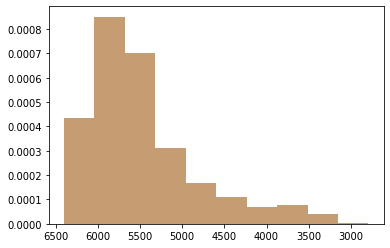

In [240]:
H = plt.hist(sim_t, density=True, alpha=.5);
H, bins, _ = H
H = plt.hist(tess.Teff, density=True, alpha=.5, bins=bins);
plt.gca().invert_xaxis()

(1.5, 150)

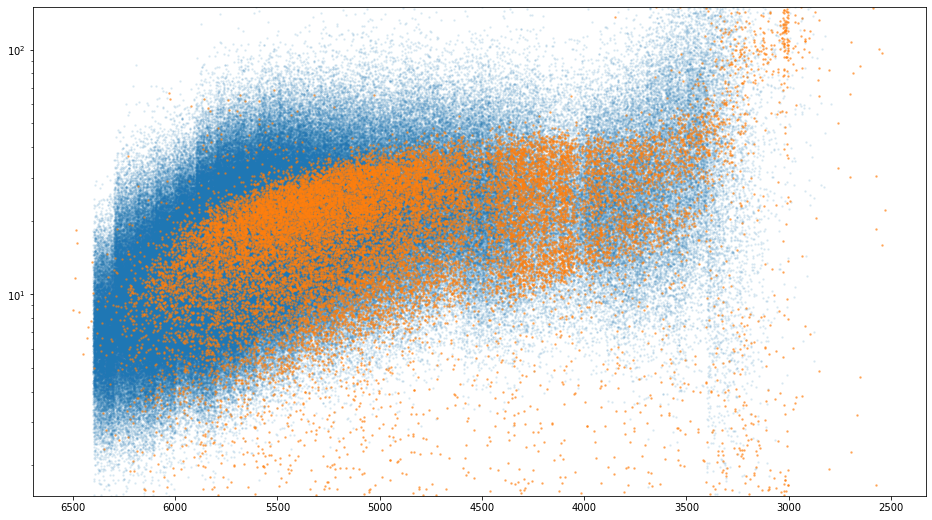

In [241]:
plt.figure(figsize=(16, 9))
plt.plot(sim_t, sim_p, ".", alpha=.1, ms=3)
plt.plot(df.teff, df.prot, ".", alpha=.5, ms=3)

plt.gca().invert_xaxis()
plt.yscale("log")
plt.ylim(1.5, 150)

Now add stars with periods up to baseline/2, with representative numbers.

In [217]:
from tqdm import trange

baseline = np.array([0, 27.4, 54.8, 82.2, 109.6, (137.0+301.4)/2, 328.8, 356.2])
sky_coverage = np.array([14.6, 63.0, 15.2, 3.0, .56, 1.4, .52, 1.7])

cvz_frac = sky_coverage[-1] / 85.4  # Fraction of all observed stars that are in the CVZ.

# b = 1
# bfrac = sky_coverage[b] / 85.4      # Stars at this baseline as a fraction of CVZ stars.

bteffs, bprots, ateffs, aprots = [], [], [], []
for b in trange(1, len(baseline)):
    
    bfrac = sky_coverage[b] / 85.4      # Stars at this baseline as a fraction of CVZ stars
    
    # Get teffs and prots at this baseline.
    teffs, prots = [], []
    for i in range(len(teff_bins)-1):

        tmask = (teff_bins[i] < tess.Teff.values) & (tess.Teff.values < teff_bins[i+1])
        nstars = len(tess.Teff.values[tmask])
        tot_nstars = int(nstars*bfrac/cvz_frac)

        teffs.append(np.random.uniform(teff_bins[i], teff_bins[i+1], tot_nstars))
        prots.append(10**(np.random.randn(tot_nstars)*period_std[i] + period_mean[i]))

    teffs = np.array([i for j in teffs for i in j])
    prots = np.array([i for j in prots for i in j])
    ateffs.append(teffs)
    aprots.append(prots)
    
    baseline_mask = prots <= baseline[b]/2
    teffs, prots = teffs[baseline_mask], prots[baseline_mask]
    
    bteffs.append(teffs)
    bprots.append(prots)

100%|██████████| 7/7 [00:10<00:00,  1.51s/it]


(1.0, 200)

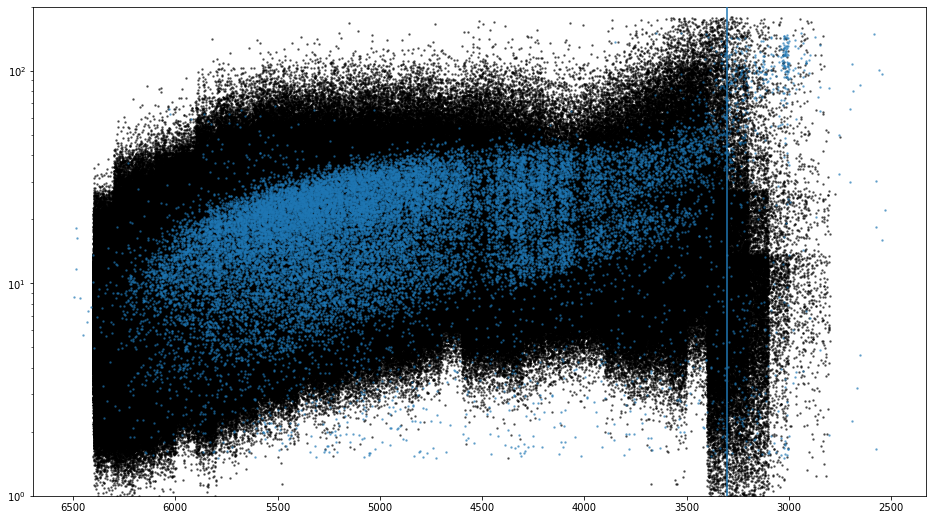

In [218]:
plt.figure(figsize=(16, 9))
# plt.plot(sim_t, sim_p, ".", alpha=.1, ms=3)
# plt.plot(df.teff, df.prot, ".", alpha=.5, ms=3)

# b = 6
# plt.plot(bteffs[b], bprots[b], ".", alpha=.1, ms=1, rasterized=True)

for b in range(len(bteffs)):
    plt.plot(bteffs[b], bprots[b], "k.", alpha=.5, ms=3)
plt.plot(df.teff, df.prot, ".", alpha=.5, ms=3)
plt.axvline(3300, zorder=10)

plt.gca().invert_xaxis()
plt.yscale("log")
plt.ylim(1., 200)

In [219]:
arr_teffs = np.array([i for j in bteffs for i in j])
arr_prots = np.array([i for j in bprots for i in j])

(0, 2000)

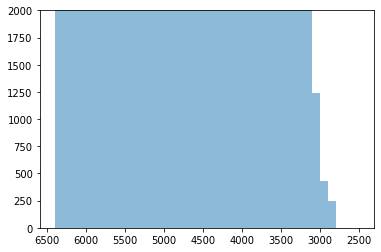

In [220]:
H, _, _ = plt.hist(arr_teffs, bins=teff_bins, density=False, alpha=.5);
kepler_hist, _, = np.histogram(df.teff.values, bins=teff_bins)
# plt.hist(tess.Teff, density=True, alpha=.5, bins=bins);
plt.gca().invert_xaxis()
plt.ylim(0, 2000)

In [221]:
teff_bins

array([2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500,
       3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600,
       4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700,
       5800, 5900, 6000, 6100, 6200, 6300, 6400])

In [222]:
H

array([0.000000e+00, 0.000000e+00, 2.000000e+00, 2.500000e+02,
       4.340000e+02, 1.239000e+03, 5.780000e+03, 1.427500e+04,
       2.932100e+04, 2.665400e+04, 4.375200e+04, 4.737700e+04,
       6.052000e+04, 6.547800e+04, 6.006700e+04, 4.713300e+04,
       4.764400e+04, 5.498900e+04, 7.905600e+04, 9.499500e+04,
       1.038680e+05, 9.454500e+04, 1.193380e+05, 1.430740e+05,
       1.758370e+05, 2.188730e+05, 2.828790e+05, 3.973980e+05,
       5.188960e+05, 7.217570e+05, 9.133110e+05, 1.202317e+06,
       1.380710e+06, 1.480688e+06, 1.421537e+06, 1.298453e+06,
       1.116594e+06, 8.739250e+05, 6.876730e+05])

In [223]:
print(sum(H[0:5])*.8, "Late M dwarfs ", teff_bins[0], teff_bins[5])
print(sum(H[5:10])*.8, "Mid M dwarfs ", teff_bins[5], teff_bins[10])
print(sum(H[10:14])*.8, "Early M dwarfs ", teff_bins[10], teff_bins[14])

548.8000000000001 Late M dwarfs  2500 3000
61815.200000000004 Mid M dwarfs  3000 3500
173701.6 Early M dwarfs  3500 3900


In [224]:
print(sum(H[0:5])*.8/sum(kepler_hist[:5]), "x more Late M dwarfs ", teff_bins[0], teff_bins[5])
print(sum(H[5:10])*.8/sum(kepler_hist[5:10]), "x more Mid M dwarfs ", teff_bins[5], teff_bins[10])
print(sum(H[10:14])*.8/sum(kepler_hist[10:14]), "x more Early M dwarfs ", teff_bins[10], teff_bins[14])
print(sum(H[14:28])*.6/sum(kepler_hist[14:28]), "x more K dwarfs ", teff_bins[14], teff_bins[28])
print(sum(H[28:34])*.2/sum(kepler_hist[28:34]), "x more G dwarfs ", teff_bins[28], teff_bins[34])

9.301694915254238 x more Late M dwarfs  2500 3000
73.1540828402367 x more Mid M dwarfs  3000 3500
129.62805970149253 x more Early M dwarfs  3500 3900
87.09395841209829 x more K dwarfs  3900 5300
155.1897915886684 x more G dwarfs  5300 5900


In [225]:
print(sum(kepler_hist[:5]))

59


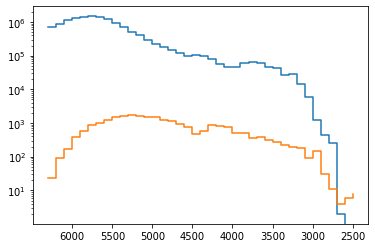

In [226]:
plt.step(teff_bins[:-1], H)
plt.step(teff_bins[:-1], kepler_hist)
plt.gca().invert_xaxis()
plt.yscale("log")

In [161]:
print(sum(H[0:5])*.8, "Late M dwarfs ", teff_bins[0], teff_bins[5])
print(sum(H[5:10])*.8, "Mid M dwarfs ", teff_bins[5], teff_bins[10])
print(sum(H[10:15])*.8, "Early M dwarfs ", teff_bins[10], teff_bins[14])

484.8 Late M dwarfs  2500 3000
59112.0 Mid M dwarfs  3000 3500
210453.6 Early M dwarfs  3500 3900


15th mag limit:

1. 484.8 Late M dwarfs  2500 3000
2. 59112.0 Mid M dwarfs  3000 3500
3. 210453.6 Early M dwarfs  3500 3900

In [4]:
print(len(south) + len(north), "stars in the CVZs")
print(len(south.iloc[south.Teff.values < 5280]) + len(north.iloc[north.Teff.values < 5280]), "KM dwarfs in the CVZs")
nbright, sbright = (north.Tmag.values < 15) & (north.Teff.values < 5280), (south.Tmag.values < 15) & (south.Teff.values < 5280)
print(len(north.iloc[nbright]) + len(south.iloc[sbright]), "bright KM dwarfs in the CVZs")

nbright14, sbright14 = (north.Tmag.values < 14) & (north.Teff.values < 5280), (south.Tmag.values < 14) & (south.Teff.values < 5280)
print(len(north.iloc[nbright14]) + len(south.iloc[sbright14]), "really bright KM dwarfs in the CVZs")

1022694 stars in the CVZs
348793 KM dwarfs in the CVZs
127139 bright KM dwarfs in the CVZs
41673 really bright KM dwarfs in the CVZs


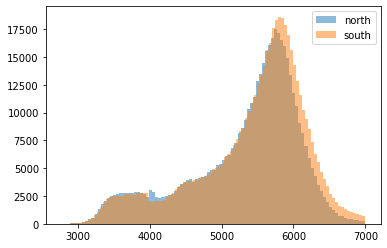

In [5]:
plt.hist(north.Teff, 100, alpha=.5, label="north");
plt.hist(south.Teff, 100, alpha=.5, label="south");
plt.legend()

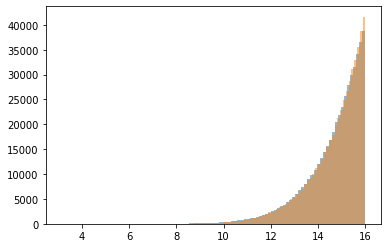

In [6]:
plt.hist(north.Tmag, 100, alpha=.5);
plt.hist(south.Tmag, 100, alpha=.5);

In [7]:
cool = south.Teff.values < 5280
print(sum(cool))
cool = north.Teff.values < 5280
print(sum(cool))

172327
176466


Load the KIC to compare.

In [8]:
from astropy.io import fits

gaia_file = "/Users/rangus/projects/data/kepler_dr2_1arcsec.fits"

with fits.open(gaia_file) as data:
    kepler = pd.DataFrame(data[1].data, dtype="float64")

In [9]:
df = pd.merge(north, south, on=["ID", "Teff", "Tmag"], how="outer")
print(sum(df.Teff.values < 4000))
print(sum(df.Teff.values < 4000))
print(sum(kepler.teff.values < 4000))

89750
89750
6288


Text(0, 0.5, 'Number of stars')

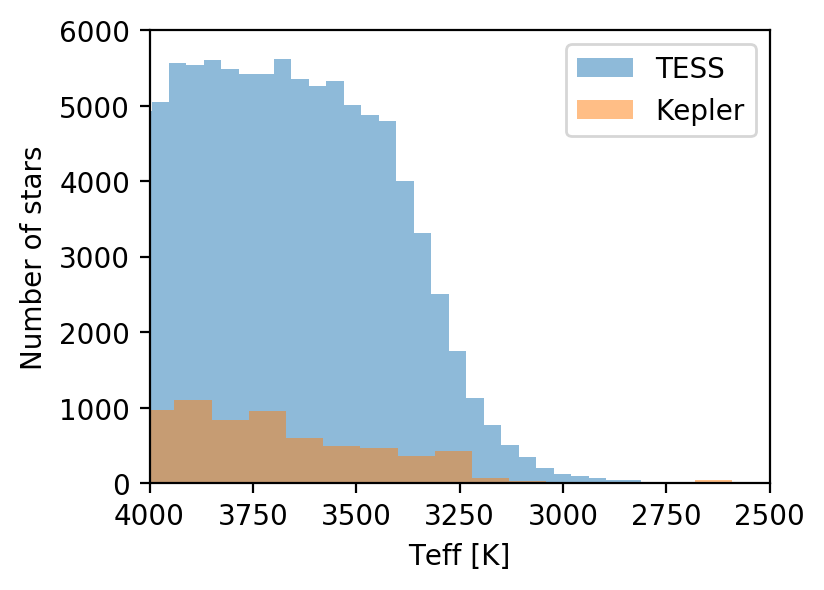

In [10]:
plt.figure(figsize=(4, 3), dpi=200)
plt.hist(df.Teff, 100, density=False, alpha=.5, label="TESS");
plt.hist(kepler.teff.values[kepler.teff.values < 7000], 50, density=False, alpha=.5, label="Kepler");
plt.legend()
plt.gca().invert_xaxis()
plt.xlim(4000, 2500)
plt.ylim(0, 6000)
plt.xlabel("Teff [K]")
plt.ylabel("Number of stars")

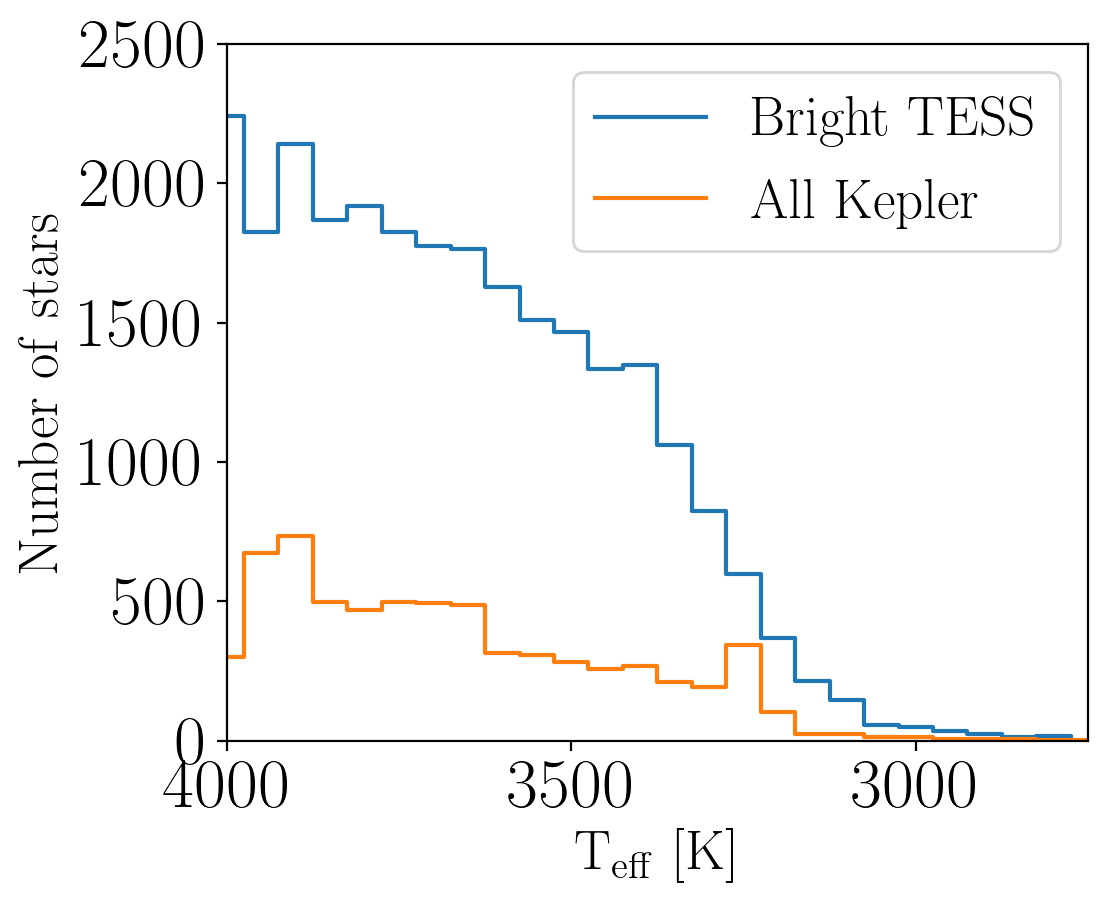

In [11]:
plotpar = {'axes.labelsize': 20,
           'font.size': 22,
           'legend.fontsize': 20,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

teff_lim = 4100

plt.figure(figsize=(6, 5), dpi=200)
# H, bins, _ = plt.hist(df.Teff.values[(df.Tmag.values < 14) & (df.Teff.values < 4000) & (2750 < df.Teff.values)],
#                       50, density=False, alpha=.5, label="TESS");
bins = np.arange(2750, teff_lim, 50)
HT, bins = np.histogram(df.Teff.values[(df.Tmag.values < 14) & (df.Teff.values < teff_lim) & (2750 < df.Teff.values)],
                       bins=bins)
plt.step(bins[:-1], HT*3.22, color="C0", where="mid", label="$\mathrm{Bright~TESS}$");
HK, bins = np.histogram(kepler.teff.values[(kepler.teff.values < teff_lim) & (2750 < kepler.teff.values)],
                       bins=bins)
plt.step(bins[:-1], HK, color="C1", where="mid", label="$\mathrm{All~Kepler}$");
plt.legend()
plt.gca().invert_xaxis()
plt.xlim(4000, 2750)
plt.ylim(0, 2500)
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Number~of~stars}$")

plt.tight_layout()
plt.savefig("kepler_tess_comparison")
plt.savefig("kepler_tess_comparison.pdf")

In [34]:
print(sum(HT)*3.22/sum(HK))

3.9889478527607367


In [52]:
print(len(df.iloc[(df.Tmag.values < 14) & (df.Teff.values < 5280)])*.8, "K and M dwarfs observed by TESS")

33338.4 K and M dwarfs observed by TESS


In [46]:
print(len(df.iloc[(df.Tmag.values < 14) & (df.Teff.values < 5280)])*3.22/len(kepler[(kepler.logg.values > 4.2) & (kepler.teff.values < 5280)]))

4.4034738949233745


In [48]:
print(len(df.iloc[(df.Tmag.values < 14) & (df.Teff.values < 3870)])*3.22/len(kepler[(kepler.logg.values > 4.2) & (kepler.teff.values < 3870)]))

5.500912301353738


In [45]:
print(len(df.iloc[df.Tmag.values < 14])*3.22/len(kepler[(kepler.logg.values > 4.2) & (kepler.teff.values < 7000)]))

5.283382796833774


In [53]:
print(bins[:23])
print(sum(HT[:23]), sum(HK[:23]))
print(sum(HT[:23])/sum(HK[:23]))
# print(HT/HK)

[2750 2800 2850 2900 2950 3000 3050 3100 3150 3200 3250 3300 3350 3400
 3450 3500 3550 3600 3650 3700 3750 3800 3850]
6163 4818
1.2791614777916147


In [11]:
print(north.ra.values[:10])
print(north.dec.values[:10])

[251.11291361 246.43175633 248.71603491 243.8037382  244.70346351
 244.69276777 249.33497539 249.9593778  250.02744819 248.49587661]
[63.27319422 62.22356768 64.09808423 63.55002236 66.64794872 67.00833243
 65.03404697 69.46232454 70.70600953 59.7401828 ]


63.2731942219403 251.112913610498


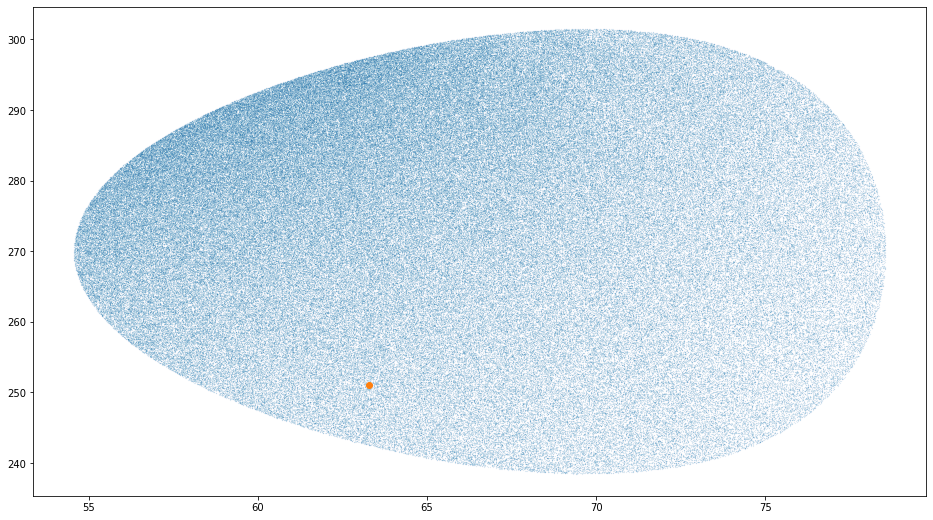

In [12]:
plt.figure(figsize=(16, 9))
plt.plot(north.dec.values, north.ra.values, ".", ms=.1)
plt.plot(north.dec.values[0], north.ra.values[0], "o")
print(north.dec.values[0], north.ra.values[0])

In [35]:
bright_m_dwarfs = (north.Vmag.values < 14) & (north.Vmag.values > 13) & (north.Teff.values < 3500)
south_bright_m_dwarfs = (south.Vmag.values < 14) & (south.Vmag.values > 13) & (south.Teff.values < 3500)
south_faint_m_dwarfs = (south.Vmag.values < 15.5) & (south.Vmag.values > 15) & (south.Teff.values < 3200)
south_16_m_dwarfs = (south.Vmag.values < 16.1) & (south.Vmag.values > 15.9) & (south.Teff.values < 3200)
south_15_m_dwarfs = (south.Tmag.values < 14.99) & (south.Tmag.values > 14.95) & (south.Teff.values < 3200)

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: 

In [37]:
# print(north.ID.values[bright_m_dwarfs])
# print(south.ID.values[south_bright_m_dwarfs])
# print(south.ID.values[south_faint_m_dwarfs])
# print(south.ID.values[south_16_m_dwarfs])
print(south.ID.values[south_15_m_dwarfs])
print(south.Tmag.values[south_15_m_dwarfs])

[262614962 177352045 294092227 141768162 149665709 141187012 260354552
 260129956 141029782 179372511 300037002  38509166 382199364 372850818
 279322643 260655797 276793233]
[14.9545002  14.95870018 14.97560024 14.98099995 14.98980045 14.95699978
 14.9677     14.96380043 14.9538002  14.97200012 14.98840046 14.98810005
 14.97459984 14.97749996 14.98760033 14.98490047 14.98960018]


In [38]:
northern_bright_mdwarfs = north.iloc[bright_m_dwarfs]
northern_bright_mdwarfs.to_csv("bright_north_CVZ_Mdwarfs.csv")

southern_bright_mdwarfs = south.iloc[south_bright_m_dwarfs]
southern_bright_mdwarfs.to_csv("bright_south_CVZ_Mdwarfs.csv")

In [39]:
from tess_stars2px import tess_stars2px_function_entry

In [40]:
# ra = north.ra.values[bright_m_dwarfs]
# dec = north.dec.values[bright_m_dwarfs]
# ticid = north.ID.values[bright_m_dwarfs]

# ra = south.ra.values[south_bright_m_dwarfs]
# dec = south.dec.values[south_bright_m_dwarfs]
# ticid = south.ID.values[south_bright_m_dwarfs]

ra = south.ra.values[south_15_m_dwarfs]
dec = south.dec.values[south_15_m_dwarfs]
ticid = south.ID.values[south_15_m_dwarfs]

outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
    tess_stars2px_function_entry(ticid[0], ra[0], dec[0])

In [41]:
outID, outSec

(array([262614962, 262614962, 262614962, 262614962, 262614962, 262614962,
        262614962, 262614962, 262614962, 262614962, 262614962, 262614962,
        262614962, 262614962, 262614962, 262614962, 262614962, 262614962,
        262614962, 262614962, 262614962, 262614962, 262614962, 262614962,
        262614962, 262614962]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 27, 28, 29, 30,
        31, 32, 33, 34, 35, 36, 37, 38, 39]))

In [42]:
for i in range(len(ra)):
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
        tess_stars2px_function_entry(ticid[i], ra[i], dec[i], scInfo=scinfo)
    print(outID[0])
    print(outSec, "\n")

262614962
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37
 38 39] 

177352045
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 33 34 35 36 37 38
 39] 

294092227
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37
 39] 

141768162
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37
 38 39] 

149665709
[ 2  3  4  5  6  7  9 10 12 13 27 29 30 32 33 34 36 37 39] 

141187012
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 34 35 36 37 38
 39] 

260354552
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 31 32 33 34 35 36 37 38
 39] 

260129956
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37
 38 39] 

141029782
[ 1  2  3  4  5  6  7  8  9 10 11 12 27 28 29 31 32 33 34 35 36 37 38 39] 

179372511
[ 1  2  3  5  6  7  8  9 10 11 12 13 27 28 29 30 31 32 33 35 36 37 38 39] 

300037002
[ 1  2  3  4  5  7  8  9 10 11 12 13 27 28 29 30 31 32 33 34 35 36 37 38
 39] 

38509166
[ 1  2  3  4  5  6 

In [22]:
# import lightkurve as lk

# from lightkurve import search_targetpixelfile
# # First we open a Target Pixel File from MAST, this one is already cached from our previous tutorial!
# tpf = search_targetpixelfile('TIC 219740029').download()

# # Then we convert the target pixel file into a light curve using the pipeline-defined aperture mask.
# lc = tpf.to_lightcurve(aperture_mask=tpf.pipeline_mask)

# import lightkurve as lk
# lc = lk.search_lightcurvefile("TIC 219740029", mission="TESS", sector=14).download().PDCSAP_FLUX

Load ASAS-SN data.

In [30]:
asas = pd.read_csv("../../data/asas-sn_cvz_north.csv")
# asas.distance_as

Calculate tangential distance

In [31]:
def tang_dist(ra1, ra2, dec1, dec2):
    delta_ra, delta_dec = ra1 - ra2, dec1 - dec2
    return np.sqrt(delta_ra**2 + delta_dec**2)

In [32]:
td = tang_dist(asas.ra, north.ra, asas.dec, north.dec)

In [34]:
min_ind = np.argmin(td.values)

In [35]:
min_ind

31

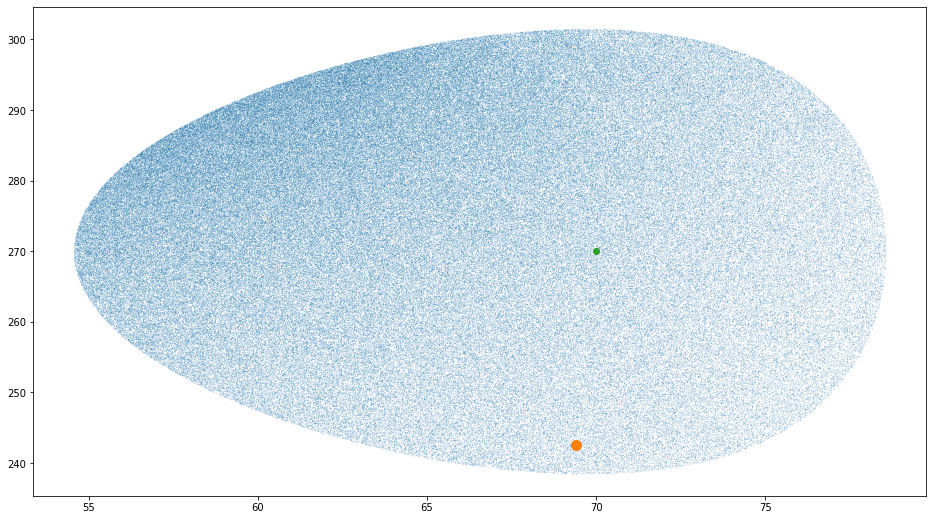

In [38]:
plt.figure(figsize=(16, 9))
plt.plot(north.dec.values, north.ra.values, ".", ms=.1)
plt.plot(north.dec.values[min_ind], north.ra.values[min_ind], "C1o", ms=10)
plt.plot(asas.dec.values[0], asas.ra.values[0], "C2o")

In [4]:
import eleanor
star = eleanor.Source(tic=38846515, sector=1)

print('Found TIC {0} (Gaia {1}), with TESS magnitude {2}, RA {3}, and Dec {4}'
     .format(star.tic, star.gaia, star.tess_mag, star.coords[0], star.coords[1]))

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector  1...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector  1 now available.
Found TIC 38846515 (Gaia 4675352109658261376), with TESS magnitude 10.3157, RA 68.9597092399964, and Dec -64.0270368810381
